In [3]:
from one.api import ONE
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

In [4]:
sessions_info = one.alyx.rest('sessions', 'list', tag='2021_Q1_IBL_et_al_Behaviour')
try:
    eids = one.to_eid(sessions_info)
except ValueError:
    eids = [d['id'] for d in sessions_info]

In [9]:
eid = eids[1]
trials = one.load_object(eid, 'trials', collection='alf')

/Users/lencacuturela/Downloads/ONE/openalyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_030/2020-03-23/001/alf/_ibl_trials.table.pqt: 100%|██████████| 58.8k/58.8k [00:00<00:00, 516kB/s]


In [12]:
eid = eids[1]
info = one.load_object(eid, 'trials', collection='alf')

In [10]:
print(trials.keys())

dict_keys(['feedback_times', 'probabilityLeft', 'contrastLeft', 'feedbackType', 'goCue_times', 'stimOn_times', 'choice', 'rewardVolume', 'firstMovement_times', 'contrastRight', 'response_times', 'intervals'])


In [1]:
# Download IBL dataset and begin processing it: identify unique animals in
# IBL dataset that enter biased blocks.  Save a dictionary with each animal
# and a list of their eids in the biased blocks

import numpy as np
from oneibl.onelight import ONE
import numpy.random as npr
import json
from collections import defaultdict
import wget
from zipfile import ZipFile
import os
from IBL_preprocessing_utils import get_animal_name
npr.seed(65)

DOWNLOAD_DATA = True  # change to True to download raw data (WARNING: this
# can take a while)

if __name__ == '__main__':
    ibl_data_path = "../../data/ibl/"
    if DOWNLOAD_DATA: # Warning: this step takes a while
        if not os.path.exists(ibl_data_path):
            os.makedirs(ibl_data_path)
        # download IBL data
        url = 'https://ndownloader.figshare.com/files/21623715'
        wget.download(url, ibl_data_path)
        # now unzip downloaded data:
        with ZipFile(ibl_data_path + "ibl-behavior-data-Dec2019.zip",
                     'r') as zipObj:
            # extract all the contents of zip file in ibl_data_path
            zipObj.extractall(ibl_data_path)

    # create directory for saving data:
    if not os.path.exists(ibl_data_path + "partially_processed/"):
        os.makedirs(ibl_data_path + "partially_processed/")

    # change directory so that ONE searches in correct directory:
    os.chdir(ibl_data_path)
    one = ONE()
    eids = one.search(['_ibl_trials.*'])
    assert len(eids) > 0, "ONE search is in incorrect directory"
    animal_list = []
    animal_eid_dict = defaultdict(list)

    for eid in eids:
        bias_probs = one.load_dataset(eid, '_ibl_trials.probabilityLeft')
        comparison = np.unique(bias_probs) == np.array([0.2, 0.5, 0.8])
        # sessions with bias blocks
        if isinstance(comparison, np.ndarray):
            # update def of comparison to single True/False
            comparison = comparison.all()
        if comparison == True:
            animal = get_animal_name(eid)
            if animal not in animal_list:
                animal_list.append(animal)
            animal_eid_dict[animal].append(eid)

    json = json.dumps(animal_eid_dict)
    f = open("partially_processed/animal_eid_dict.json",  "w")
    f.write(json)
    f.close()

    np.savez('partially_processed/animal_list.npz', animal_list)

/Users/lencacuturela/opt/anaconda3/envs/glmhmm-IBL/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


### Psytrack Notebook

In [31]:
import os
import re
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from oneibl.onelight import ONE
import wget

ibl_data_path = '../data_IBL'



In [29]:
# Downloading data, then unzipping manually in folder, then preprocessing with below code from Psytrack notebook

# current_cwd = os.getcwd()
# SPATH = current_cwd + "/Figures"
# ibl_data_path = SPATH + '/ibl-behavioral-data-Dec2019'
# # os.chdir(ibl_data_path)
# # print(os.getcwd())

# # import subprocess

# # def runcmd(cmd, verbose = False, *args, **kwargs):

# #     process = subprocess.Popen(
# #         cmd,
# #         stdout = subprocess.PIPE,
# #         stderr = subprocess.PIPE,
# #         text = True,
# #         shell = True
# #     )
# #     std_out, std_err = process.communicate()
# #     if verbose:
# #         print(std_out.strip(), std_err)
# #     pass

# # runcmd('echo "Hello, World!"', verbose = True)

# # runcmd("wget https://ndownloader.figshare.com/files/21623715", verbose = True)

# # Search all sessions that have these dataset types.
# required_vars = ['_ibl_trials.choice', '_ibl_trials.contrastLeft',
#                  '_ibl_trials.contrastRight','_ibl_trials.feedbackType']
# one = ONE()
# eids = one.search(required_vars)

# mouseData = pd.DataFrame()
# for eid in eids:
#     lab, _, subject, date, session = eid.split("/")    
#     sess_vars = {
#         "eid": eid,
#         "lab": lab,
#         "subject": subject,
#         "date": date,
#         "session": session,
#     }
#     mouseData = mouseData.append(sess_vars, sort=True, ignore_index=True)

# all_vars = ["contrastLeft", "contrastRight", "choice", "feedbackType", "probabilityLeft"]
# df = pd.DataFrame()

# all_mice = []
# for j, s in enumerate(mouseData["subject"].unique()):
#     print("\rProcessing " + str(j+1) + " of " + str(len(mouseData["subject"].unique())), end="")
#     mouse = mouseData[mouseData["subject"]==s].sort_values(['date', 'session']).reset_index()
#     for i, row in mouse.iterrows():
#         myVars = {}
#         for v in all_vars:
#             filename = "_ibl_trials." + v + ".npy"
#             var_file = os.path.join(ibl_data_path, row.eid, "alf", filename)
#             myVars[v] = list(np.load(var_file).flatten())

#         num_trials = len(myVars[v])
#         myVars['lab'] = [row.lab]*num_trials
#         myVars['subject'] = [row.subject]*num_trials
#         myVars['date'] = [row.date]*num_trials
#         myVars['session'] = [row.session]*num_trials

#         all_mice += [pd.DataFrame(myVars, columns=myVars.keys())]
        
# df = pd.concat(all_mice, ignore_index=True)

# df = df[df['choice'] != 0]        # dump mistrials
# df = df[df['feedbackType'] != 0]  # 3 anomalous trials from ZM_1084, omit
# df.loc[np.isnan(df['contrastLeft']), "contrastLeft"] = 0
# df.loc[np.isnan(df['contrastRight']), "contrastRight"] = 0
# df.loc[df["contrastRight"] < 0, "contrastLeft"] = np.abs(df.loc[df["contrastRight"] < 0, "contrastRight"])
# df.loc[df["contrastRight"] < 0, "contrastRight"] = 0  # 81 anomalous trials in CSHL_002, correct
# df["correctSide"] = df["feedbackType"] * df["choice"]      # new column to indicate correct answer
# df.loc[df["correctSide"]==1, "correctSide"] = 0
# df.loc[df["correctSide"]==-1, "correctSide"] = 1
# df.loc[df["feedbackType"]==-1, "feedbackType"] = 0
# df.loc[df["choice"]==1, "choice"] = 0
# df.loc[df["choice"]==-1, "choice"] = 1
# df.to_csv(SPATH+"ibl_processed.csv", index=False)

Processing 101 of 101

In [76]:
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')

In [33]:
dfAll.head()

,contrastLeft,contrastRight,choice,feedbackType,probabilityLeft,lab,subject,date,session,correctSide
0,1.0,0.0,1,0,1.0,angelakilab,IBL-T1,2019-02-09,1,0
1,1.0,0.0,1,0,1.0,angelakilab,IBL-T1,2019-02-09,1,0
2,0.0,1.0,1,1,1.0,angelakilab,IBL-T1,2019-02-09,1,1
3,0.5,0.0,0,1,0.5,angelakilab,IBL-T1,2019-02-09,1,0
4,0.5,0.0,0,1,0.9,angelakilab,IBL-T1,2019-02-09,1,0


In [46]:
print("contrastLeft: ", np.unique(dfAll['contrastLeft']))   # [0, 0.0625, 0.125, 0.25, 0.5, 1.0] and [0.04, 0.08]
print("contrastRight: ", np.unique(dfAll['contrastRight'])) # [0, 0.0625, 0.125, 0.25, 0.5, 1.0] and [0.04, 0.08]
print("choice: ", np.unique(dfAll['choice']))               # [0, 1]
print("feedbackType: ", np.unique(dfAll['feedbackType']))   # [0, 1]
print("correctSide: ", np.unique(dfAll['correctSide']))               # [0, 1]
print("lab: ", np.unique(dfAll['lab']))
print("subject: ", np.unique(dfAll['subject']))
subjects = np.unique(dfAll['subject'])

contrastLeft:  [0.     0.04   0.0625 0.08   0.125  0.25   0.5    1.    ]
contrastRight:  [0.     0.04   0.0625 0.08   0.125  0.25   0.5    1.    ]
choice:  [0 1]
feedbackType:  [0 1]
correctSide:  [0 1]
lab:  ['angelakilab' 'churchlandlab' 'cortexlab' 'danlab' 'hoferlab' 'mainenlab'
 'mrsicflogellab' 'wittenlab' 'zadorlab']
subject:  ['CSHL049' 'CSHL_001' 'CSHL_002' 'CSHL_003' 'CSHL_004' 'CSHL_005'
 'CSHL_006' 'CSHL_007' 'CSHL_008' 'CSHL_010' 'CSHL_012' 'CSHL_014'
 'CSHL_015' 'CSH_ZAD_001' 'CSH_ZAD_002' 'CSH_ZAD_003' 'CSH_ZAD_004'
 'CSH_ZAD_005' 'CSH_ZAD_006' 'CSH_ZAD_007' 'CSH_ZAD_010' 'DY_001' 'DY_002'
 'DY_003' 'DY_005' 'DY_006' 'DY_007' 'DY_009' 'DY_010' 'DY_011' 'IBL-T1'
 'IBL-T2' 'IBL-T3' 'IBL-T4' 'IBL_001' 'IBL_002' 'KS002' 'KS003' 'KS004'
 'KS005' 'KS014' 'KS015' 'KS016' 'KS017' 'KS018' 'KS019' 'KS020' 'KS021'
 'KS022' 'KS023' 'KS024' 'KS025' 'NYU-01' 'NYU-02' 'NYU-04' 'NYU-06'
 'NYU-07' 'NYU-09' 'NYU-12' 'NYU-13' 'SWC_001' 'SWC_008' 'SWC_012'
 'SWC_013' 'SWC_014' 'SWC_015' 'SW

In [49]:
subjectsWitten = np.unique(dfAll[dfAll['lab'] == 'wittenlab']['subject'])
print(subjectsWitten)

['ibl_witten_02' 'ibl_witten_03' 'ibl_witten_04' 'ibl_witten_05'
 'ibl_witten_06' 'ibl_witten_07' 'ibl_witten_12' 'ibl_witten_13'
 'ibl_witten_14' 'ibl_witten_15' 'ibl_witten_16']


In [51]:
def getMouse(dfAll, subject, p=5):
    df = dfAll[dfAll['subject']==subject]   # Restrict data to the subject specified
    
    cL = np.tanh(p*df['contrastLeft'])/np.tanh(p)   # tanh transformation of left contrasts
    cR = np.tanh(p*df['contrastRight'])/np.tanh(p)  # tanh transformation of right contrasts
    inputs = dict(cL = np.array(cL)[:, None], cR = np.array(cR)[:, None])

    dat = dict(
        subject=subject,
        lab=np.unique(df["lab"])[0],
        contrastLeft=np.array(df['contrastLeft']),
        contrastRight=np.array(df['contrastRight']),
        date=np.array(df['date']),
        dayLength=np.array(df.groupby(['date','session']).size()),
        correct=np.array(df['feedbackType']),
        correctSide=np.array(df['correctSide']),
        probL=np.array(df['probabilityLeft']),
        inputs = inputs,
        y = np.array(df['choice'])
    )
    
    return dat

d = getMouse(dfAll, subject='ibl_witten_15', p=5)
print(np.unique(d['date']))

['2019-08-08' '2019-08-09' '2019-08-12' '2019-08-13' '2019-08-14'
 '2019-08-15' '2019-08-16' '2019-08-19' '2019-08-20' '2019-08-21'
 '2019-08-22' '2019-08-23' '2019-08-26' '2019-08-27' '2019-08-28'
 '2019-08-29' '2019-08-30' '2019-09-09' '2019-09-10' '2019-09-11'
 '2019-09-12' '2019-09-13' '2019-09-16' '2019-09-17' '2019-09-18'
 '2019-09-19' '2019-09-23' '2019-09-24' '2019-09-25' '2019-09-26'
 '2019-09-27' '2019-09-30' '2019-10-03' '2019-10-04' '2019-10-07'
 '2019-10-08' '2019-10-09' '2019-10-10' '2019-10-11' '2019-10-14'
 '2019-10-15' '2019-10-16' '2019-10-17' '2019-10-23' '2019-10-24'
 '2019-10-28' '2019-10-29' '2019-10-30' '2019-10-31' '2019-11-01'
 '2019-11-04' '2019-11-05' '2019-11-06' '2019-11-07' '2019-11-08'
 '2019-11-11' '2019-11-12' '2019-11-13' '2019-11-14' '2019-11-15'
 '2019-11-18' '2019-11-19' '2019-11-20' '2019-11-21' '2019-11-22'
 '2019-11-25' '2019-11-26' '2019-11-27']


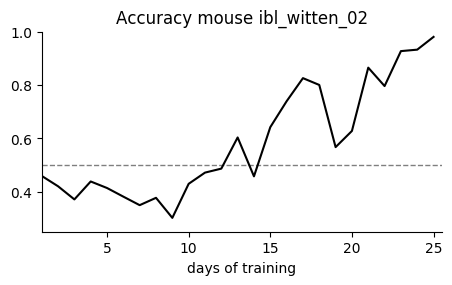

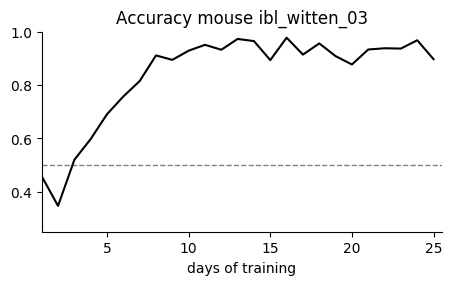

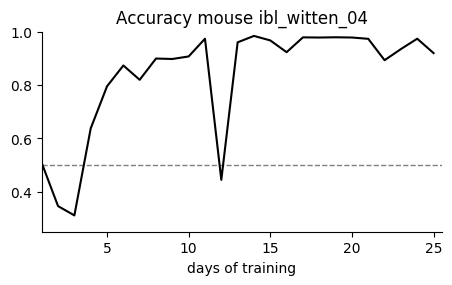

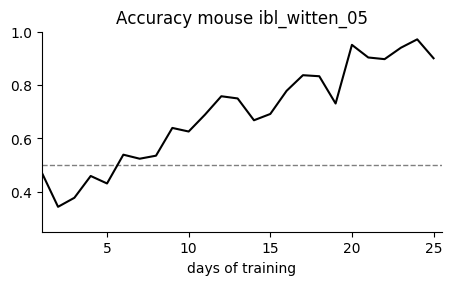

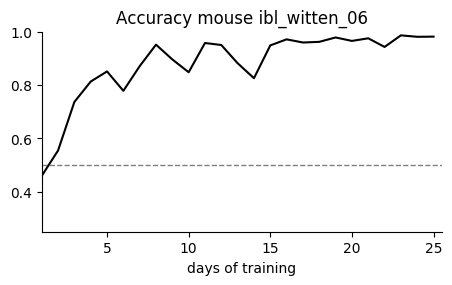

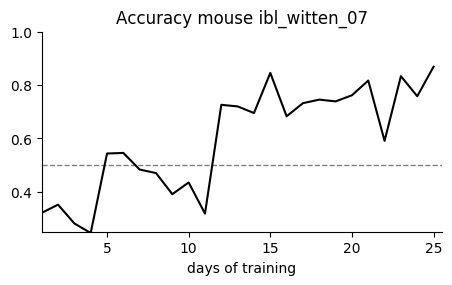

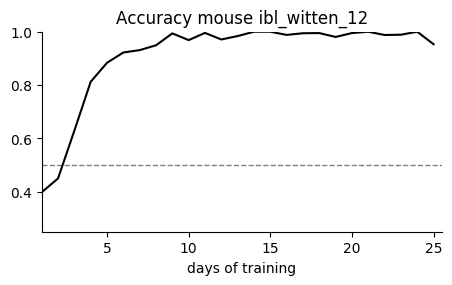

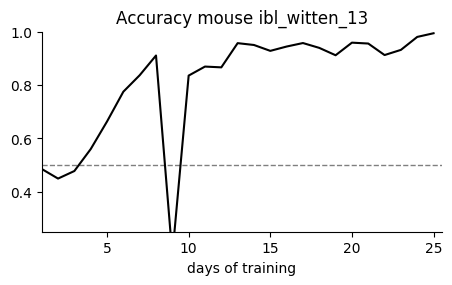

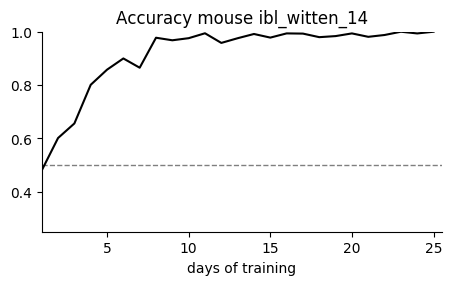

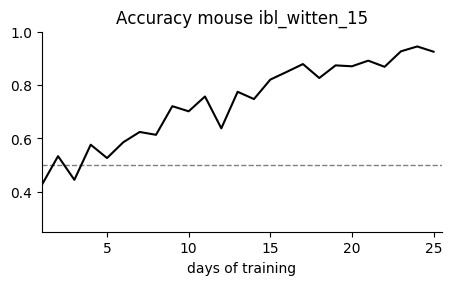

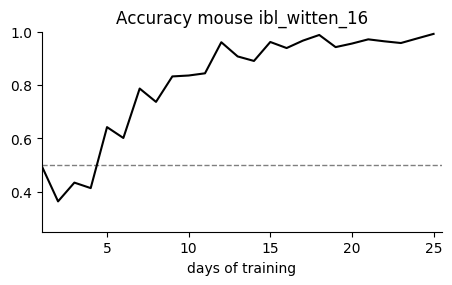

In [57]:
from datetime import date, datetime, timedelta

#subject = 'ibl_witten_15'
for subject in subjectsWitten:
    outData = getMouse(dfAll, subject, 5)
    easy_trials = (outData['contrastLeft'] > 0.45).astype(int) | (outData['contrastRight'] > 0.45).astype(int)

    perf = []
    for d in np.unique(outData['date']):
        date_trials = (outData['date'] == d).astype(int)
        inds = (date_trials * easy_trials).astype(bool)
        perf += [np.average(outData['correct'][inds])]

    dates = np.unique([datetime.strptime(i, "%Y-%m-%d") for i in outData['date']])
    dates = np.arange(len(dates)) + 1

    # Plotting
    fig = plt.figure(figsize=(4,2))

    plt.plot(dates[:25], perf[:25], color="black", linewidth=1.5, zorder=2) # only look at first 25 days
    # plt.scatter(dates[9], perf[9], c="white", s=30, edgecolors="black", linestyle="--", lw=0.75, zorder=5, alpha=1) # first session >50% accuracy has circle

    plt.axhline(0.5, color="black", linestyle="--", lw=1, alpha=0.5, zorder=0)

    plt.xticks(np.arange(0,26,5))
    plt.yticks([0.4,0.6,0.8,1.0])
    plt.ylim(0.25,1.0)
    plt.xlim(1, 25.5)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.title('Accuracy mouse ' + subject)
    plt.xlabel("days of training")
    plt.subplots_adjust(0,0,1,1) 

In [92]:
subject = 'ibl_witten_16'

def get_mouse_design(dfAll, subject):
    data = dfAll[dfAll['subject']==subject]   # Restrict data to the subject specified
    p=5
    data['cL'] = np.tanh(p*data['contrastLeft'])/np.tanh(p) # tanh transformation of left contrasts
    data['cR'] = np.tanh(p*data['contrastRight'])/np.tanh(p) # tanh transformation of right contrasts
    # data = getMouse(dfAll, subject, p=5)
    # print(data['y'].shape)
    dateToKeep = np.unique(data['date'])[0:40]
    print(dateToKeep)
    dataTemp = data.loc[data['date'].isin(list(dateToKeep))]
    print(dataTemp)
    
get_mouse_design(dfAll, subject)

['2019-08-08' '2019-08-09' '2019-08-12' '2019-08-13' '2019-08-14'
 '2019-08-15' '2019-08-16' '2019-08-19' '2019-08-20' '2019-08-21'
 '2019-08-22' '2019-08-23' '2019-08-26' '2019-08-27' '2019-08-28'
 '2019-08-29' '2019-08-30' '2019-09-09' '2019-09-10' '2019-09-11'
 '2019-09-12' '2019-09-13' '2019-09-16' '2019-09-17' '2019-09-18'
 '2019-09-19' '2019-09-20' '2019-09-23' '2019-09-24' '2019-09-25'
 '2019-09-26' '2019-09-27' '2019-09-30' '2019-10-03' '2019-10-04'
 '2019-10-07' '2019-10-08' '2019-10-09' '2019-10-10' '2019-10-11']
         contrastLeft  contrastRight  choice  feedbackType  probabilityLeft  \
3397133        0.5000          0.000       0             1              0.5   
3397134        0.0000          1.000       0             0              0.5   
3397135        1.0000          0.000       0             1              0.8   
3397136        0.5000          0.000       0             1              0.5   
3397137        1.0000          0.000       1             0              0.5 

/Users/lencacuturela/opt/anaconda3/envs/glmhmm-IBL/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lencacuturela/opt/anaconda3/envs/glmhmm-IBL/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [63]:
a = np.load('/Users/lencacuturela/Desktop/Research/github/LC_PWM_GLM-HMM/data/W073_psycho_True_cutoff_100_stage-filter4_X-design.npy')

In [64]:
print(a)

[[ 1.          1.83236677  0.86409145  0.          0.          0.        ]
 [ 1.         -1.55788346 -0.67241496  1.44408979 -1.          1.        ]
 [ 1.         -0.71032091 -1.44066816 -1.18933797  1.         -1.        ]
 ...
 [ 1.         -0.71032091 -1.44066816 -0.31152872  1.         -1.        ]
 [ 1.         -0.71032091 -1.44066816 -1.18933797  1.          1.        ]
 [ 1.         -0.33951229  0.09583824 -1.18933797  1.          1.        ]]
